# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

<b>Answer: </b>
The dataset collected is related to 17 campaigns that occurred 
between May 2008 and November 2010, corresponding to a total of 79354 contacts. 
During these phone campaigns, an attractive long-term deposit application, with good interest rates, was offered. 
For each contact, a large number of attributes was stored and if there was a success (the target variable). 
For the whole database considered, there were 6499 successes (8% success rate).

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2154]:
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import BinaryEncoder
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from matplotlib.colors import ListedColormap
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [1999]:
bank = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [2000]:
bank.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [2003]:
features = pd.DataFrame(bank[["age", "job","marital","default", "education","housing","loan","campaign","pdays","previous", "poutcome","emp.var.rate","cons.price.idx","cons.conf.idx","euribor3m","nr.employed","y"]]) 								

### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')




<b>Answer:</b> The Results field y will need to be converted into a binary 1 for yes and 0 for no, so both categorical and numeric models can be used.  The Education field
will be converted into an ordinal categorical field representing the degree of education.  Marital status, job, loan and housing fields will be converted using one 
hot encoding to make these categorical fields numberic, this will allow for linear models and their derivatives to be used on this data.  To ensure that data is consistent, "unknown" categories in each column will be dropped.  This allows for more accurate comparison of features accross the data as unknowns are akin to nulls.


In [2007]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   default         41188 non-null  object 
 4   education       41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   campaign        41188 non-null  int64  
 8   pdays           41188 non-null  int64  
 9   previous        41188 non-null  int64  
 10  poutcome        41188 non-null  object 
 11  emp.var.rate    41188 non-null  float64
 12  cons.price.idx  41188 non-null  float64
 13  cons.conf.idx   41188 non-null  float64
 14  euribor3m       41188 non-null  float64
 15  nr.employed     41188 non-null  float64
 16  y               41188 non-null  object 
dtypes: float64(5), int64(4), object

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

<b>Answer:</b>The business objective is to analyze the dataset of portuguese banks and its features to determine what features can be use to create the most optimal 
prediction model for predicting whether a patron will open a deposit account or not.  In addition to determining the most critical features, the business objective is 
to determine what model performs the best in predicting which patrons will open an account given the selected features.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [2012]:
features = features.loc[features['marital'] != "unknown"]

In [2014]:
features = features.loc[features['job'] != "unknown"]

In [2016]:
features = features.loc[features['education'] != "unknown"]  

In [2018]:
features = features.loc[features['housing'] != "unknown"] 

In [2020]:
features = features.loc[features['loan'] != "unknown"] 

In [2022]:
features = features.loc[features['default'] != "unknown"] 

In [2024]:
result = features[["y"]]

In [2026]:
label_encoder = LabelEncoder()
result = label_encoder.fit_transform(result["y"])

In [2028]:
features.drop('y', axis=1, inplace=True)


In [2030]:
col_transformer = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['marital','job','poutcome','housing', 'loan','default' ]), (OrdinalEncoder(categories = [['illiterate','basic.4y','basic.6y', 'basic.9y','high.school', 'professional.course',\
      'university.degree']]), ['education']), remainder='passthrough')

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [2033]:
X_train, X_test, y_train, y_test = train_test_split(features,result,test_size = 0.3, random_state = 22)

In [2035]:
X_train.head()

,age,job,marital,default,education,housing,loan,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
19292,40,admin.,divorced,no,university.degree,yes,no,2,999,0,nonexistent,1.4,93.444,-36.1,4.967,5228.1
18773,31,services,single,no,high.school,no,no,4,999,0,nonexistent,1.4,93.918,-42.7,4.968,5228.1
21766,30,technician,single,no,professional.course,yes,no,3,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1
15371,39,self-employed,married,no,university.degree,no,no,1,999,0,nonexistent,1.4,93.918,-42.7,4.957,5228.1
8141,40,admin.,married,no,high.school,no,no,3,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [2038]:
baseline = Pipeline([("col_transformer", col_transformer), ('poly_nomial',PolynomialFeatures(degree=2, include_bias= False)), ('linreg', LinearRegression())])

In [2040]:
baseline = baseline.fit(X_train, y_train) 

In [2041]:
preds = baseline.predict(X_test)

In [2042]:
mse_base = mean_squared_error(y_test, preds)

In [2043]:
print(mse_base)

0.27681212013915996


In [2044]:
baseline.score(X_train,y_train)

0.23885181639725173

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [2052]:
train_score = [0, 0, 0,0]
test_score = [0, 0, 0,0]
average_fit_time = [0, 0, 0,0]

In [2054]:
logreg = Pipeline([("col_transformer", col_transformer),("scalar",StandardScaler()),('logreg', LogisticRegression(random_state=22, solver='saga', max_iter=1000))])

In [2056]:
start_time = time.time()
logreg.fit(X_train, y_train)
end_time = time.time()
preds = logreg.predict(X_test)

fit_time_log_reg = end_time - start_time
average_fit_time[0] = fit_time_log_reg




In [2058]:
mse_logreg = mean_squared_error(y_test, preds)

In [2060]:
print(mse_logreg)

0.11151197113807806


### Problem 9: Score the Model

What is the accuracy of your model?

In [2063]:
log_reg_acc_train = logreg.score(X_train,y_train)
log_reg_acc_test = logreg.score(X_test,y_test)
train_score[0] = log_reg_acc_train
test_score[0] =  log_reg_acc_test

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [2066]:
knn =  Pipeline([("col_transformer", col_transformer),('knn', KNeighborsClassifier())])

In [2068]:
# Fit the model to the training data
start_time = time.time()
knn.fit(X_train, y_train)
end_time = time.time()
fit_time_knn = end_time - start_time
average_fit_time[1] = fit_time_knn

In [2074]:
preds = knn.predict(X_test)

In [2076]:
mse_knn = mean_squared_error(y_test, preds)

In [2078]:
print(mse_knn)

0.12146058817098503


In [2080]:
knn_acc_train = knn.score(X_train,y_train)
knn_acc_test = knn.score(X_test,y_test)
train_score[1] = knn_acc_train
test_score[1] =  knn_acc_test

In [2082]:
start_time = time.time()
dtree = Pipeline([("col_transformer", col_transformer),('dtree', DecisionTreeClassifier())]).fit(X_train, y_train)
end_time = time.time()
fit_time_dtree = end_time - start_time
average_fit_time[2] = fit_time_dtree

In [2084]:
preds = dtree.predict(X_test)

In [2086]:
mse_dtree = mean_squared_error(y_test, preds)

In [2088]:
print(mse_dtree)

0.17404613534492183


In [2090]:
dtree_acc_train = dtree.score(X_train,y_train)
dtree_acc_test = dtree.score(X_test,y_test)
train_score[2] = dtree_acc_train
test_score[2] =  dtree_acc_test

In [2092]:
start_time = time.time()
svm = Pipeline([("col_transformer", col_transformer),('svm', SVC(random_state = 22))]).fit(X_train, y_train)
end_time = time.time()
fit_time_svm = end_time - start_time
average_fit_time[3] = fit_time_svm

In [2093]:
preds = svm.predict(X_test)

In [2094]:
mse_svm = mean_squared_error(y_test, preds)

In [2095]:
print(mse_svm)

0.11326117852847928


In [2096]:
svm_acc_train = svm.score(X_train,y_train)
svm_acc_test = svm.score(X_test,y_test)
train_score[3] = svm_acc_train
test_score[3] =  svm_acc_test

In [2104]:
res_dict = {'model': ['Logistic Regression', 'KNN','Decision Tree','SVC'],
           'train score': train_score,
           'test score': test_score,
           'average fit time':average_fit_time}
results_df = pd.DataFrame(res_dict).set_index('model')

In [2106]:
results_df

,train score,test score,average fit time
model,,,
Logistic Regression,0.886088,0.888488,8.981343
KNN,0.903378,0.878539,0.078601
Decision Tree,0.993534,0.825954,0.238241
SVC,0.884963,0.886739,10.388903


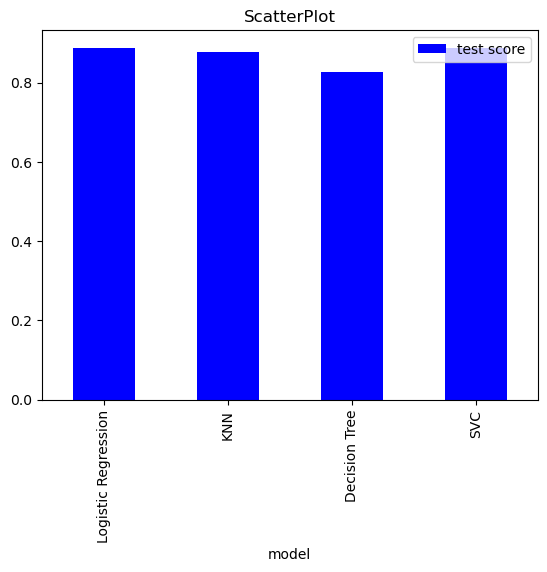

In [2110]:
results_df = results_df.reset_index()
results_df.plot(kind='bar',
        x='model',
        y='test score',
        color='blue')

# set the title
plt.title('ScatterPlot')

# show the plot
plt.show()

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

<b>Answer: </b> The first step is to determine the most important features of the model and reduce the dimentionality of the test data inorder to improve training performance.  Then using gridsearch, the optimum hyperparameters will be generated for each model and compared to the actual pervious results when the models were not optimized.

In [2114]:
bank = bank.loc[bank['marital'] != "unknown"]
bank = bank.loc[bank['job'] != "unknown"]
bank = bank.loc[bank['education'] != "unknown"]
bank = bank.loc[bank['housing'] != "unknown"]
bank = bank.loc[bank['loan'] != "unknown"]
bank = bank.loc[bank['default'] != "unknown"]

col_transformer2 = make_column_transformer((OneHotEncoder(drop = 'if_binary'), ['marital','job','poutcome','housing', 'loan','default' ]), (OrdinalEncoder(categories = [['illiterate','basic.4y','basic.6y', 'basic.9y','high.school', 'professional.course',\
      'university.degree']]), ['education']), remainder='passthrough')
transformed_data = col_transformer2.fit_transform(bank)

# Get feature names
feature_names = col_transformer2.get_feature_names_out()

# Create a new DataFrame from the transformed data
df_transformed = pd.DataFrame(transformed_data, columns=feature_names)

label_encoder = LabelEncoder()
df_transformed["remainder__y"] = label_encoder.fit_transform(df_transformed["remainder__y"])

df_transformed = df_transformed.filter(['onehotencoder__marital_divorced','onehotencoder__marital_married', 'ordinalencoder__education', 'remainder__y'\
,'onehotencoder__marital_single', 'onehotencoder__job_admin', 'onehotencoder__job_blue-collar', 'onehotencoder__job_entrepreneur', 'onehotencoder__job_housemaid'\
,'onehotencoder__job_management','onehotencoder__job_retired','onehotencoder__job_self-employed','remainder__campaign', 'remainder__previous','remainder__emp.var.rate','remainder__cons.conf.idx'\
,'remainder__nr.employed', 'onehotencoder__job_unemployed','onehotencoder__default_yes','onehotencoder__housing_yes'], axis=1)

df_transformed.corr()

         

,onehotencoder__marital_divorced,onehotencoder__marital_married,ordinalencoder__education,remainder__y,onehotencoder__marital_single,onehotencoder__job_blue-collar,onehotencoder__job_entrepreneur,onehotencoder__job_housemaid,onehotencoder__job_management,onehotencoder__job_retired,onehotencoder__job_self-employed,remainder__campaign,remainder__previous,remainder__emp.var.rate,remainder__cons.conf.idx,remainder__nr.employed,onehotencoder__job_unemployed,onehotencoder__default_yes,onehotencoder__housing_yes
onehotencoder__marital_divorced,1.000000,-0.421361,-0.009025,-0.012211,-0.243287,-0.049467,0.008312,0.010715,-0.004371,0.068582,-0.008394,0.008353,-0.005524,0.030410,-0.008537,0.028208,0.005318,-0.003603,-0.003143
onehotencoder__marital_married,-0.421361,1.000000,-0.142538,-0.031525,-0.777133,0.114522,0.049748,0.050002,0.071192,0.060784,0.010165,-0.003809,-0.028955,0.050476,0.058205,0.055043,-0.000179,0.008551,-0.007143
ordinalencoder__education,-0.009025,-0.142538,1.000000,0.038087,0.158712,-0.512709,0.015300,-0.140316,0.192854,-0.135702,0.089504,0.008990,0.017258,-0.007900,0.075008,-0.002784,-0.008800,0.001974,0.019193
remainder__y,-0.012211,-0.031525,0.038087,1.000000,0.042191,-0.067496,-0.019582,-0.000223,-0.002428,0.102376,-0.003301,-0.069206,0.228003,-0.305365,0.061638,-0.364230,0.020917,-0.003776,0.010071
onehotencoder__marital_single,-0.243287,-0.777133,0.158712,0.042191,1.000000,-0.088158,-0.058975,-0.060914,-0.073109,-0.112603,-0.005048,-0.001723,0.034802,-0.075089,-0.056329,-0.078445,-0.003498,-0.006645,0.009820
onehotencoder__job_blue-collar,-0.049467,0.114522,-0.512709,-0.067496,-0.088158,1.000000,-0.092043,-0.072774,-0.136961,-0.097473,-0.092174,-0.004778,-0.043282,0.037380,-0.105870,0.047492,-0.075323,-0.004744,-0.009844
onehotencoder__job_entrepreneur,0.008312,0.049748,0.015300,-0.019582,-0.058975,-0.092043,1.000000,-0.029287,-0.055119,-0.039227,-0.037095,-0.007073,-0.014051,0.014835,-0.032406,0.029013,-0.030313,-0.001909,0.004216
onehotencoder__job_housemaid,0.010715,0.050002,-0.140316,-0.000223,-0.060914,-0.072774,-0.029287,1.000000,-0.043580,-0.031015,-0.029329,-0.004767,-0.005083,0.028025,0.037712,0.017673,-0.023967,-0.001510,-0.004382
onehotencoder__job_management,-0.004371,0.071192,0.192854,-0.002428,-0.073109,-0.136961,-0.055119,-0.043580,1.000000,-0.058370,-0.055198,-0.011438,0.003327,-0.009984,0.001232,0.007064,-0.045106,-0.002841,-0.007784
onehotencoder__job_retired,0.068582,0.060784,-0.135702,0.102376,-0.112603,-0.097473,-0.039227,-0.031015,-0.058370,1.000000,-0.039283,-0.006229,0.073667,-0.129088,0.091680,-0.155369,-0.032101,-0.002022,0.001032


Below is a graph of the correlation matrix showing how each important feature corresponds to the patrons decison to open deposit account

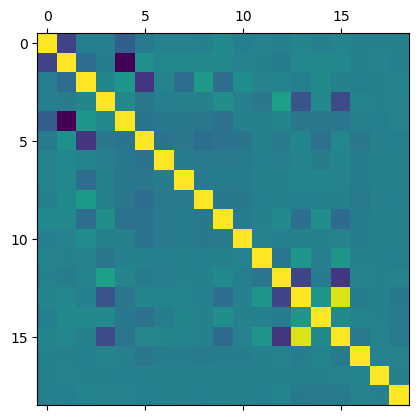

In [2117]:
plt.matshow(df_transformed.corr())
plt.show()

Using Permutation Importance, the most critical features that the baseline model uses for predictions are shown below

In [2122]:
r = permutation_importance(baseline, X_train, y_train,
                           n_repeats=30,
                           random_state=0)

for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_train.columns[i]:<7} "
              f"{r.importances_mean[i]:.3f}"
              f" +/- {r.importances_std[i]:.3f}")

pdays   363.212 +/- 9.276
poutcome 275.424 +/- 3.732
euribor3m 27.159 +/- 0.219
previous 5.441 +/- 0.085
emp.var.rate 4.228 +/- 0.036
nr.employed 3.609 +/- 0.041
job     2.308 +/- 1.020
cons.conf.idx 0.242 +/- 0.007
cons.price.idx 0.108 +/- 0.004
campaign 0.015 +/- 0.003
age     0.008 +/- 0.001
education 0.006 +/- 0.001
marital 0.006 +/- 0.001
loan    0.004 +/- 0.001
housing 0.001 +/- 0.000


Below each model is optimized using Grid Search and the results will be later compared to baseline model and non-optimized models

In [2125]:
log_reg_param_grid = {
    'logreg__C': [0.01, 0.05, 0.0005, 0.1, 1, 10, 15, 20],
    'logreg__penalty': ['l1', 'l2']
}

In [2127]:
start_time = time.time()
log_reg_grid = GridSearchCV(logreg, param_grid=log_reg_param_grid).fit(X_train,y_train)
end_time = time.time()

fit_time_log_reg = end_time - start_time
average_fit_time[0] = fit_time_log_reg

log_acc_train = log_reg_grid.score(X_train,y_train)
log_acc_test = log_reg_grid.score(X_test,y_test)
train_score[0] = log_acc_train
test_score[0] =  log_acc_test

print("Best Parameters:", log_reg_grid.best_params_)

C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 718, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^

Best Parameters: {'logreg__C': 0.01, 'logreg__penalty': 'l1'}


In [2128]:


knn_param_grid = {
    'knn__n_neighbors': [1, 2, 3, 4, 5, 6,7]
}

In [2129]:
start_time = time.time()
knn_grid = GridSearchCV(knn, param_grid=knn_param_grid).fit(X_train,y_train)
end_time = time.time()

fit_time_knn_grid = end_time - start_time
average_fit_time[1] = fit_time_knn_grid

knn_acc_train = knn_grid.score(X_train,y_train)
knn_acc_test = knn_grid.score(X_test,y_test)
train_score[1] = knn_acc_train
test_score[1] =  knn_acc_test

print("Best Parameters:", knn_grid.best_params_)

C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 718, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^

Best Parameters: {'knn__n_neighbors': 1}


In [2130]:
tree_param_grid = {'dtree__criterion':['gini','entropy'],'dtree__max_depth':[4,5,6,7,8,9,10,11,12,15]}

In [2131]:
start_time = time.time()
tree_grid = GridSearchCV(dtree, param_grid=tree_param_grid).fit(X_train,y_train)
end_time = time.time()

fit_time_tree_grid = end_time - start_time
average_fit_time[2] = fit_time_tree_grid

tree_acc_train = tree_grid.score(X_train,y_train)
tree_acc_test = tree_grid.score(X_test,y_test)
train_score[2] = tree_acc_train
test_score[2] =  tree_acc_test

print("Best Parameters:", tree_grid.best_params_)

C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 718, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^

Best Parameters: {'dtree__criterion': 'gini', 'dtree__max_depth': 4}


C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 718, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^

In [2132]:
svm_param_grid = {
    'svm__gamma' : [0.0001],
    'svm__C' : [0.01, 0.05]
}

In [2133]:
start_time = time.time()
svm_grid = GridSearchCV(svm, param_grid=svm_param_grid).fit(X_train,y_train)
end_time = time.time()

fit_time_svm_grid = end_time - start_time
average_fit_time[3] = fit_time_svm_grid

svm_acc_train = svm_grid.score(X_train,y_train)
svm_acc_test = svm_grid.score(X_test,y_test)
train_score[3] = svm_acc_train
test_score[3] =  svm_acc_test
print("Best Parameters:", svm_grid.best_params_)

C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\metrics\_scorer.py", line 444, in _passthrough_scorer
    return estimator.score(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 718, in score
    Xt = transform.transform(Xt)
         ^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\kwb33\anaconda3\Lib\site-packages\sklearn\utils\_set_output.py", line 140, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^

Best Parameters: {'svm__C': 0.01, 'svm__gamma': 0.0001}


In [2134]:
res_dict = {'model': ['Logistic Regression', 'KNN','Decision Tree','SVC'],
           'train score': train_score,
           'test score': test_score,
           'average fit time':average_fit_time}
results_df = pd.DataFrame(res_dict).set_index('model')

In [2135]:
results_df

,train score,test score,average fit time
model,,,
Logistic Regression,0.886978,0.887504,394.713989
KNN,0.993252,0.835902,22.242151
Decision Tree,0.887259,0.887941,14.887024
SVC,0.887212,0.888488,133.347789


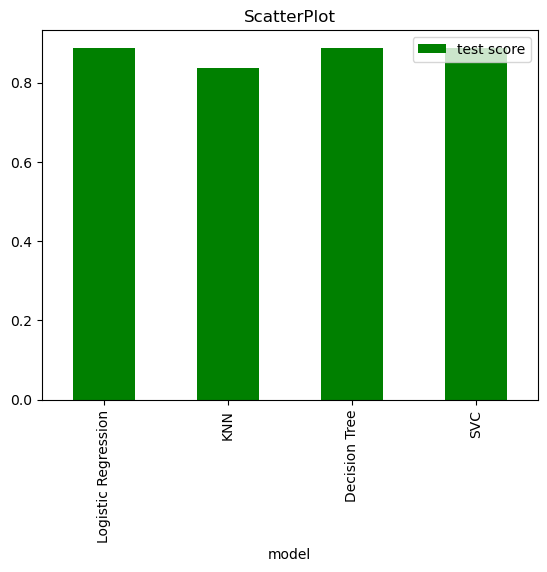

In [2148]:
results_df = results_df.reset_index()
results_df.plot(kind='bar',
        x='model',
        y='test score',
        color='green')

# set the title
plt.title('ScatterPlot')

# show the plot
plt.show()

##### Questions